## Name : Pat O'Dowd
## Number : 8273375

# CE5012 Assignment 3:

The assignment notebook should be named following the convention 'student_id_CE5012_Assignment3.ipynb'.

## Part-1:

This week’s assignment involves an in-depth exploration of two major research works in foundation models: Masked Auto Encoders (MAE) and OpenAI's CLIP.

MAE: https://arxiv.org/abs/2111.06377

OpenAI CLIP: https://openai.com/research/clip

During our lecture, we discussed four different methodologies employed to build large-scale vision foundation models:

*   Contrastive Learning → SimCLR
*   Knowledge Distillation → DINO
*   Token Masking → MAE
*   Vision-Language Fusion → CLIP

We covered only the first two models in our lectures. Now, as part of the assignment, you are required to understand the remaining two models, MAEs and CLIP, in detail and prepare notes on each topic. Your notes should be part of the notebook and should cover the following major points:

- A quick overview of the architecture.

- The training strategies used.

- Loss functions employed.

- Key differences between the MAEs and CLIP architectures (2 to 3 points).


This is a significant topic, and hence, some of the questions in the QUIZ will be on these foundation models.

## Evaluation Criteria:

1. 3 points: MAE Presentation
2. 3 points: CLIP Presentation
3. 4 points: Key differences between MAE and CLIP



## Your Part-1 Work Starts From Here

** Ends Here **

## MAE Presentation

Masked autoencoders (MAE) are scalable self-supervised learners for computer vision. 
### Architecture
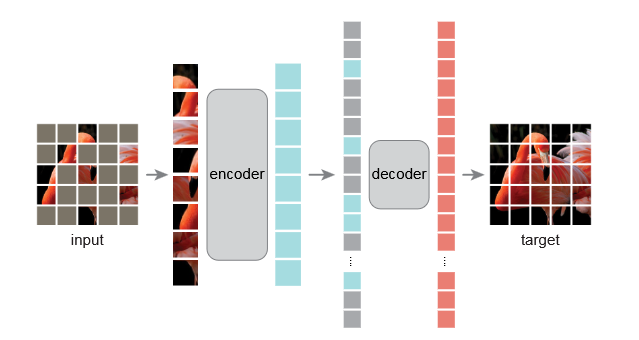

The MAE is an asymmetric encoder-decoder architecture. The encoder is a Visual Transformer (ViT) model that operates on a subset of the original image (only the visible image patchs). The decoder is a lightweight model both shallower and narrower than the encoder. The fact that the encoder operates on a subset of the image and the lightweight nature of the decoder ensure a more scalable solution. Self supervised learning is achieved through the use of a loss function that compares the reconstructed image from the decoder with the original image. Nore the loss is computed only on the masked patchs. Once learning is completed the decoder aspect of the model can be discarded and the encoder model used for image recognition.

### Funcional aspects
The functional aspects of the architecture of the MAE are as follows.
1. Generation of non-overlapping image patchs of the original image.
2. Sampling of a random selection of the image patchs and masking of the remaining patchs. The number of sampled image patchs
   could for example represent 25% of the total number of image patchs.
3. The sampled image patchs are fed into the encoder. 
4. The encoder encodes the visible patchs
5. The decoder takes as input the encoded visible patchs and the mask tokens. Note that positional embeddings are added to the the tokens for the visible     patchs and for the mask tokens. This ensures that the token positions in the original image are avaialble to the decoder.
6. The decoder reconstructs the image
7. The loss function is the Mean Squared Error (MSE between the reconstructed image and the original image in pixel space. Note loss is computed only on      the masked patchs

### MAE Strengths
The model trains on a subset of the image data and employs a lightweight decoder. Because of this the model provides a more scalable solution as less computing resources are required compared to some other models. In addition the model does not require data augmentation as in effect the role of data augmentation is manly performed by the random masking. Finally the accuracy of the model appears to improve steadily with longer training.



## ClIP Presentation

### Contrastive Language-Image Pre-training (CLIP)

### Architecture
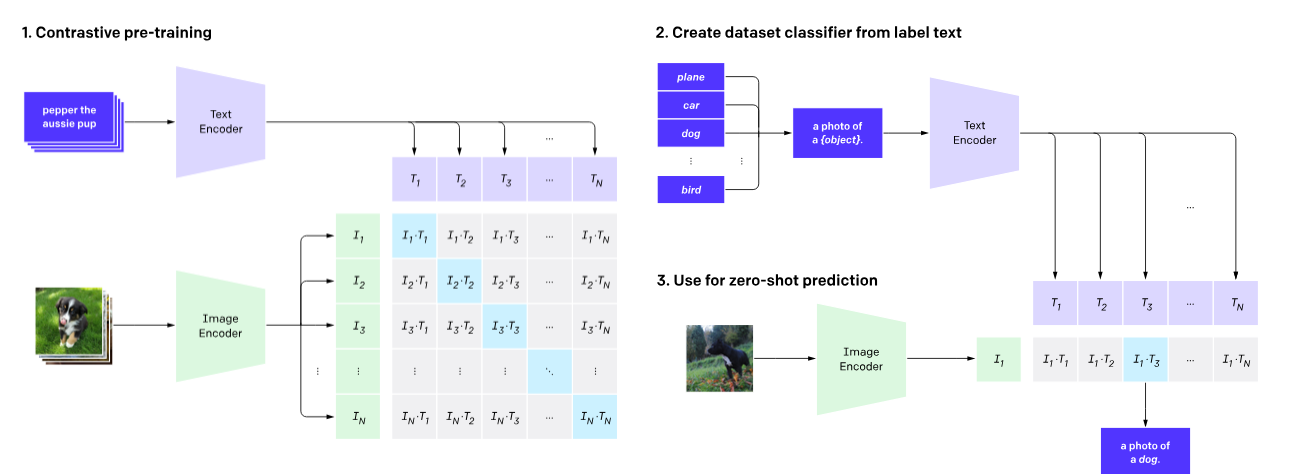

The input to a CLIP model is a set of images and their corresponding set of captions. The model is trained by finding similiarity between the image and the caption. This is achieved using 2 separate encoders, one for the text (image caption) and the other for the image endocer. The text encoder is a transformer model and the image encoder is typically a Vision Transformer (ViT) eventhough a ResNet-50 can also be used. 

### Functional Aspectsabs


### CLIP Strengths
Does not require large manually labelled datasets
Does not need additional training examples for new tasks
benchmark performance vs real performance



## Key Differences between MAE and CLIP



# Part-2

The aim is to utilize the pre-trained DINO and CLIP models for feature extraction on three specific classes: airplanes, bonsai trees, and butterflies. We will then visualize these features in a lower dimension using t-SNE (t-Distributed Stochastic Neighbor Embedding). The expected outcome is to observe three distinct clusters, each corresponding to a specific class, even though the models haven't been trained on this particular dataset.

## Explanation:

1. We will leverage pre-trained DINO and CLIP models to extract features from images belonging to the three target classes. These extracted features represent the characteristics learned by the models to identify objects in images.
2. t-SNE, a dimensionality reduction technique, will be used to project these high-dimensional features into a lower-dimensional space for visualization.
3. Ideally, the visualization will reveal three separate clusters, where each cluster groups images belonging to the same class (airplanes, bonsai, or butterflies). This would demonstrate the models' ability to capture class-specific information even without being trained on this specific dataset.

## Additional Notes:

1. The provided notebook should guide you through the detailed steps of implementing this objective.
2. This approach assumes that the pre-trained models have learned generic features that can be applied to classify unseen data, even if not explicitly trained on the specific classes of interest.

## Evaluation Criteria:

1. 3 points: DINO feature visualization clearly separates the three classes.
2. 3 points: CLIP feature visualization clearly separates the three classes.
3. 4 points: Identify and discuss failure cases using your own images. This demonstrates a deeper understanding of the limitations of the models and the potential challenges with generalizability.



In [2]:
# Required for openAI CLIP
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

[notice] A new release of pip is available: 24.2 -> 25.1
[notice] To update, run: python -m pip install --upgrade pip
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-4bdzj2v_
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-4bdzj2v_
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369490 sha256=b470ceabbb08d5feb0c59d9747c66c704f3d0ba1c3b90dbf58534bc3d57db0a8
  Stored in directory: /tmp/pip-ephem-wheel-cache-nn5r8hsl/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip

[notice] A new release of pip is available: 24.2 -> 25.1
[notice] To update, run: python -m pip install --

In [3]:
# Import the modules needed

# File IO
import os
import zipfile

# PyTorch related
import torch
import torchvision.transforms as transforms
from torchvision.datasets import Caltech101
from torch.utils.data import DataLoader

# Visualization
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


In [4]:
# Function to load dataset from zip file
# Note: Please download the dataset from the assignment page

def load_dataset_from_zip(zip_path, transform):
    images = []
    targets = []
    targets_name = []

    class_to_id = {}  # Dictionary to map class names to class IDs
    next_id = 0  # Counter for assigning class IDs

    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        for class_name in zip_ref.namelist():
            if class_name.endswith('/'):  # Skip directories
                continue
            class_images = zip_ref.open(class_name)
            image = Image.open(class_images).convert("RGB")
            images.append(transform(image))

            # Extract class name and convert to class ID
            class_name = os.path.basename(os.path.dirname(class_name))
            if class_name not in class_to_id:
                class_to_id[class_name] = next_id
                next_id += 1
            class_id = class_to_id[class_name]

            targets.append(class_id)
            targets_name.append(class_name)

    return images, targets, targets_name

# Define transformations for image pre-processing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Function to display images with labels
def display_few_samples(images, labels, num_images_per_class=3):
    unique_labels = set(labels)

    # Create subplots
    fig, axes = plt.subplots(len(unique_labels), num_images_per_class, figsize=(15, 3*len(unique_labels)))

    # Display images for each class
    for i, label in enumerate(unique_labels):
        # Find indices of images belonging to the current class
        class_indices = [idx for idx, lbl in enumerate(labels) if lbl == label]

        # Select two random indices from the class
        selected_indices = np.random.choice(class_indices, size=min(len(class_indices), num_images_per_class), replace=False)

        # Display images
        for j, idx in enumerate(selected_indices):
            image = images[idx].permute(1, 2, 0)  # Convert (C, H, W) to (H, W, C)
            axes[i, j].imshow(image)
            axes[i, j].set_title(label)
            axes[i, j].axis('off')

    plt.tight_layout()
    plt.show()

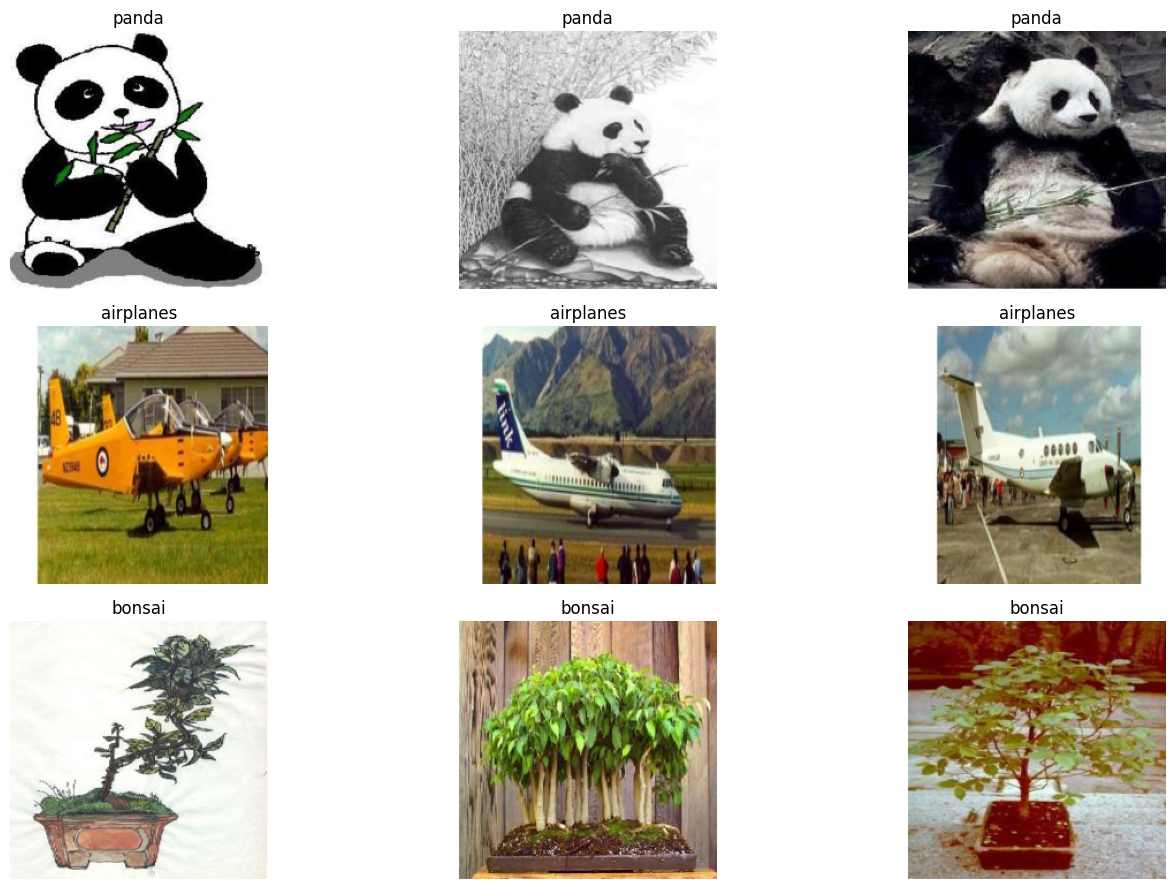

In [5]:
# Load dataset from zip file
zip_path = "Content/CE5012_Assignment_Dataset.zip"  # Specify the path to your zip file

images, targets, targets_name = load_dataset_from_zip(zip_path, transform)
display_few_samples(images, targets_name)

In [6]:
# Define class names
class_names = ['airplanes', 'bonsai', 'panda']

## Your Part-2 Work Starts From Here

1. Define data loader
2. Load model
3. Extract the features
4. Convert them to numpy format
5. Reduce dimensionality of features using t-SNE
6. Plot t-SNE visualization as a 2D plot
**Note**: use label feature in plt.scatter to display class names as legends


In [7]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 24.7 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 27.1 MB/s eta 0:00:00

[notice] A new release of pip is available: 24.2 -> 25.1
[notice] To update, run: python -m pip install --upgrade pip


In [8]:
# Imports
import torchvision
from transformers import CLIPProcessor, CLIPModel
from torchvision.models import resnet50, ResNet50_Weights,vit_b_16,vit_b_16
from sklearn.manifold import TSNE

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
import clip
device = "cuda" if torch.cuda.is_available() else "cpu"

In [10]:
image_dataset = torchvision.datasets.ImageFolder(root='Content/CE5012_Assignment_Dataset/101_ObjectCategories_mini/',transform=transform)
data_loader = torch.utils.data.DataLoader(image_dataset,
                                          batch_size=72,shuffle=False)


In [11]:
def plot_featureSpace(X,labels,Title):
    plt.figure(figsize=(10, 10))
    scatter = plt.scatter(X[:, 0], X[:, 1], c=labels,label=class_names,
                      cmap='Set1',alpha=0.5)
    plt.colorbar(scatter)
    plt.title(Title)

    plt.show()

    return

# Using CLIP API

100%|███████████████████████████████████████| 338M/338M [00:10<00:00, 33.2MiB/s]


torch.Size([72, 512]) torch.Size([3, 512])


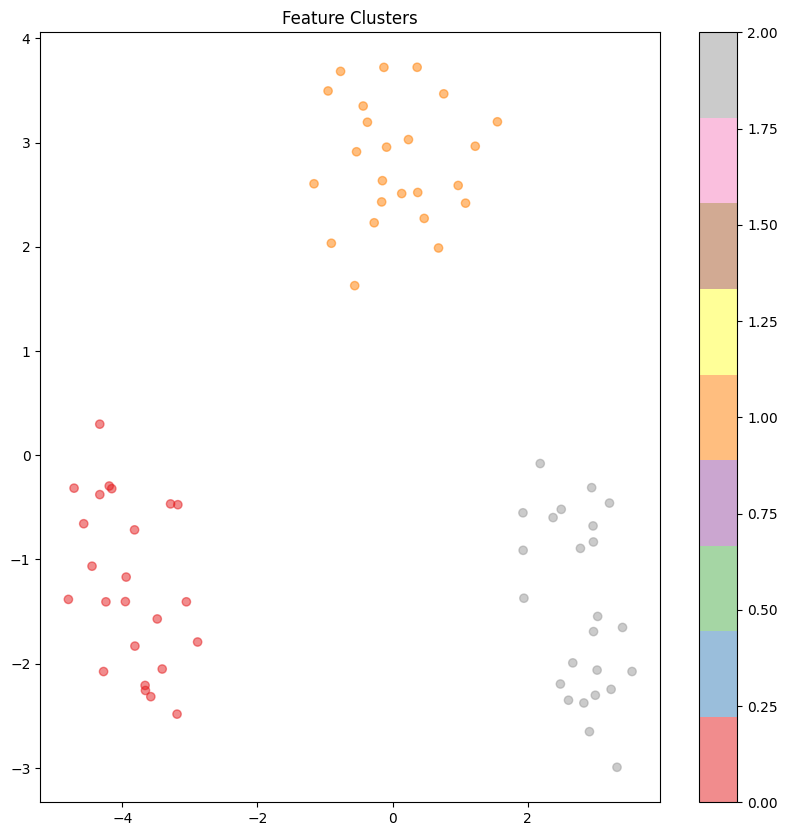

In [12]:

text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}") for c in class_names]).to(device)
model, preprocess = clip.load('ViT-B/32', device)
for i, data in enumerate(data_loader, 0):
        # basic training loop
        inputs, labels = data
        image_features = model.encode_image(inputs.to(device))
        text_features = model.encode_text(text_inputs.to(device))
        print(image_features.shape,text_features.shape)


labels = labels.to("cpu").numpy()
feature_space=image_features.detach().to("cpu").numpy()


# Function to plot the feature clusters



tsne = TSNE(n_components=2, init="random", learning_rate="auto",
            random_state=42)

feature_tsne = tsne.fit_transform(feature_space)
plot_featureSpace(feature_tsne,labels,"Feature Clusters",)

In [13]:
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

[notice] A new release of pip is available: 24.2 -> 25.1
[notice] To update, run: python -m pip install --upgrade pip


# Using CLIPModel and ClipProcessor

torch.Size([72, 50, 768])


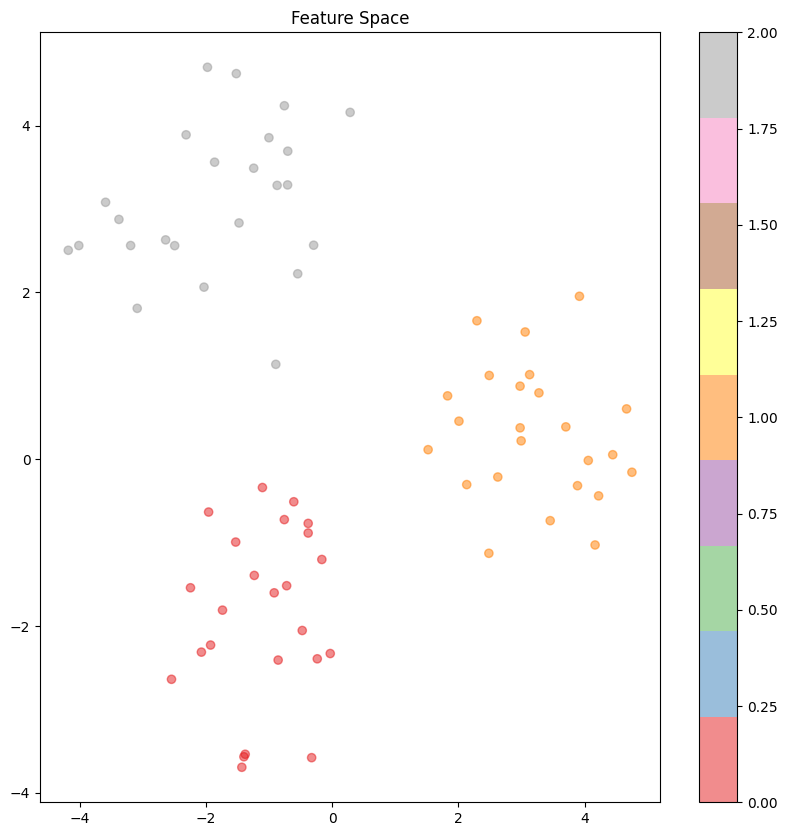

In [18]:
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
for i, data in enumerate(data_loader, 0):
        # basic training loop
        inputs, labels = data
        inputs = processor(text=class_names,images=inputs, return_tensors="pt",do_rescale=False)
        pixel_values = inputs["pixel_values"]
        with torch.inference_mode():
            outputs = model.vision_model(pixel_values)
            image_embeds = outputs.last_hidden_state.to(device)
            print(image_embeds.shape)
        image_embeds = image_embeds.reshape(72,768*50)


tsne = TSNE(n_components=2, init="random", learning_rate="auto",
            random_state=42)

feature_space= image_embeds.detach().to("cpu").numpy()

feature_tsne = tsne.fit_transform(feature_space)
# Plot the Latent Space
plot_featureSpace(feature_tsne,labels,"Feature Space",)


# CLIP using Pipeline 


In [21]:

# NOT WORKING
from transformers.pipelines.pt_utils import KeyDataset
from transformers import pipeline
clip1 = pipeline(
    model="openai/clip-vit-base-patch32",
    task="feature-extraction"
)
clip = pipeline(
   task="zero-shot-image-classification",
   model="openai/clip-vit-base-patch32",
   torch_dtype=torch.bfloat16,
   device=device
)
#sim_scores = clip(imagePIL,candidate_labels=class_names)
pipeline_dataset = clip(images=image_dataset,candidate_labels=class_names)
for out in clip(pipeline_dataset):
    print(out)
#embeds = clip1(image_dataset,candidate_labels=class_names)


Device set to use cuda:0
Device set to use cuda


NotImplementedError: Subclasses of Dataset should implement __getitem__.

In [70]:
print(embeds)

In [272]:
# checking available models in torchvision
import torchvision
all_models = torchvision.models.list_models() 
print(all_models)

['alexnet', 'convnext_base', 'convnext_large', 'convnext_small', 'convnext_tiny', 'deeplabv3_mobilenet_v3_large', 'deeplabv3_resnet101', 'deeplabv3_resnet50', 'densenet121', 'densenet161', 'densenet169', 'densenet201', 'efficientnet_b0', 'efficientnet_b1', 'efficientnet_b2', 'efficientnet_b3', 'efficientnet_b4', 'efficientnet_b5', 'efficientnet_b6', 'efficientnet_b7', 'efficientnet_v2_l', 'efficientnet_v2_m', 'efficientnet_v2_s', 'fasterrcnn_mobilenet_v3_large_320_fpn', 'fasterrcnn_mobilenet_v3_large_fpn', 'fasterrcnn_resnet50_fpn', 'fasterrcnn_resnet50_fpn_v2', 'fcn_resnet101', 'fcn_resnet50', 'fcos_resnet50_fpn', 'googlenet', 'inception_v3', 'keypointrcnn_resnet50_fpn', 'lraspp_mobilenet_v3_large', 'maskrcnn_resnet50_fpn', 'maskrcnn_resnet50_fpn_v2', 'maxvit_t', 'mc3_18', 'mnasnet0_5', 'mnasnet0_75', 'mnasnet1_0', 'mnasnet1_3', 'mobilenet_v2', 'mobilenet_v3_large', 'mobilenet_v3_small', 'mvit_v1_b', 'mvit_v2_s', 'quantized_googlenet', 'quantized_inception_v3', 'quantized_mobilenet_v2